In [1]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 690.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.5 MB/s eta 0:00:00


In [2]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, confusion_matrix
import numpy as np
import math
from PIL import Image
import seaborn as sns
from vit_pytorch import ViT, SimpleViT



In [3]:
import os
import pickle
import numpy as np
import urllib.request
import tarfile

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def download_cifar10(data_dir):
    """Download and extract CIFAR-10 dataset."""
    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    file_name = url.split('/')[-1]
    file_path = os.path.join(data_dir, file_name)

    # Create the directory if it doesn't exist
    if not os.path.exists(data_dir):
        print(f'Creating directory {data_dir}...')
        os.makedirs(data_dir)

    if not os.path.exists(file_path):
        print('Downloading CIFAR-10 dataset...')
        urllib.request.urlretrieve(url, file_path)
        print('Download complete.')

        print('Extracting files...')
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(path=data_dir)
        print('Extraction complete.')


def load_cifar10_data(data_dir):
    # Check if dataset exists, if not download it
    if not os.path.exists(os.path.join(data_dir, 'cifar-10-batches-py')):
        download_cifar10(data_dir)

    # Initialize arrays to hold the training and test images and labels
    train_images, train_labels, test_images, test_labels = [], [], [], []

    # Load all the training batches
    for i in range(1, 6):
        batch_name = os.path.join(data_dir, 'cifar-10-batches-py', 'data_batch_' + str(i))
        batch = unpickle(batch_name)
        train_images.append(batch[b'data'])
        train_labels.append(batch[b'labels'])

    # Load the test batch
    test_batch = unpickle(os.path.join(data_dir, 'cifar-10-batches-py', 'test_batch'))
    test_images.append(test_batch[b'data'])
    test_labels.append(test_batch[b'labels'])

    # Convert to numpy arrays and reshape
    train_images = np.concatenate(train_images).reshape(-1, 3, 32, 32)
    train_labels = np.concatenate(train_labels)
    test_images = np.concatenate(test_images).reshape(-1, 3, 32, 32)
    test_labels = np.concatenate(test_labels)

    return train_images, train_labels, test_images, test_labels

# Example usage
data_dir = './data'  # Update this to the path where you want to store the CIFAR-10 dataset
train_images, train_labels, test_images, test_labels = load_cifar10_data(data_dir)


Creating directory ./data...
Download complete.
Extracting files...
Extraction complete.


In [4]:
# Define CIFAR-10 classes
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


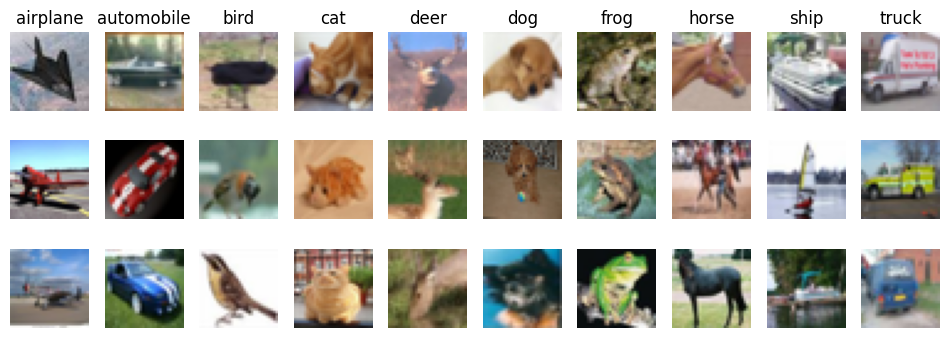

In [5]:
def show_samples(images, labels, classes, samples_per_class=3):
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(labels == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(images[idx].transpose(1, 2, 0))  # Convert from (3, 32, 32) to (32, 32, 3)
            plt.axis('off')
            if i == 0:
                plt.title(cls)

# Show the samples
plt.figure(figsize=(12, 4))
show_samples(train_images, train_labels, cifar10_classes)
plt.show()


In [6]:
train_images[0]

array([[[ 59,  43,  50, ..., 158, 152, 148],
        [ 16,   0,  18, ..., 123, 119, 122],
        [ 25,  16,  49, ..., 118, 120, 109],
        ...,
        [208, 201, 198, ..., 160,  56,  53],
        [180, 173, 186, ..., 184,  97,  83],
        [177, 168, 179, ..., 216, 151, 123]],

       [[ 62,  46,  48, ..., 132, 125, 124],
        [ 20,   0,   8, ...,  88,  83,  87],
        [ 24,   7,  27, ...,  84,  84,  73],
        ...,
        [170, 153, 161, ..., 133,  31,  34],
        [139, 123, 144, ..., 148,  62,  53],
        [144, 129, 142, ..., 184, 118,  92]],

       [[ 63,  45,  43, ..., 108, 102, 103],
        [ 20,   0,   0, ...,  55,  50,  57],
        [ 21,   0,   8, ...,  50,  50,  42],
        ...,
        [ 96,  34,  26, ...,  70,   7,  20],
        [ 96,  42,  30, ...,  94,  34,  34],
        [116,  94,  87, ..., 140,  84,  72]]], dtype=uint8)

In [7]:
# Adjusted parameters for CIFAR-10
v = SimpleViT(
    image_size = 32,  # CIFAR-10 images are 32x32
    patch_size = 4,   # Adjust patch size (32 must be divisible by patch_size)
    num_classes = 10, # CIFAR-10 has 10 classes
    dim = 512,
    depth = 4,
    heads = 8,
    mlp_dim = 2048,
    channels = 3,
)



In [8]:
device = torch.device('cuda')
model = v.to(device)

parameter_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
# Estimate size in VRAM
model_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
model_size_megabytes = model_size_bytes / (1024 ** 2)
print(f"Estimated Model Size in VRAM: {model_size_megabytes:.2f} MB")

print(f"Parameter Count: {parameter_count:,} ")


Estimated Model Size in VRAM: 48.19 MB
Parameter Count: 12,633,706 


In [9]:
# Hyperparameters
num_epochs = 30
batch_size = 256#128#64
learning_rate = 0.001
weight_decay = 0.0001

In [10]:
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert numpy array to PIL Image
        image = Image.fromarray(image.transpose(1, 2, 0))


        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations for the training set
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(),     # Random horizontal flip
    transforms.RandomRotation(15),         # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Random color jitter
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])
# trying more augmentations:
"""
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),  # Increased range
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # More aggressive jitter
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.25), ratio=(0.3, 3.3), value=0),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# tryin in between:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Keep the random crop with padding
    transforms.RandomHorizontalFlip(),     # Keep the random horizontal flip
    transforms.RandomRotation(22),         # Midway rotation range
    # Replace RandomAffine with a more moderate adjustment
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
    # Slightly less aggressive color jitter than the second set, more than the first
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.05),
    # Use RandomPerspective with a reduced effect
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.ToTensor(),
    # Optional: Include RandomErasing with adjusted parameters
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
"""

# Transformations - Adjust as needed
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create custom datasets
train_dataset = CustomCIFAR10Dataset(train_images, train_labels, transform=train_transform)
test_dataset = CustomCIFAR10Dataset(test_images, test_labels, transform=test_transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


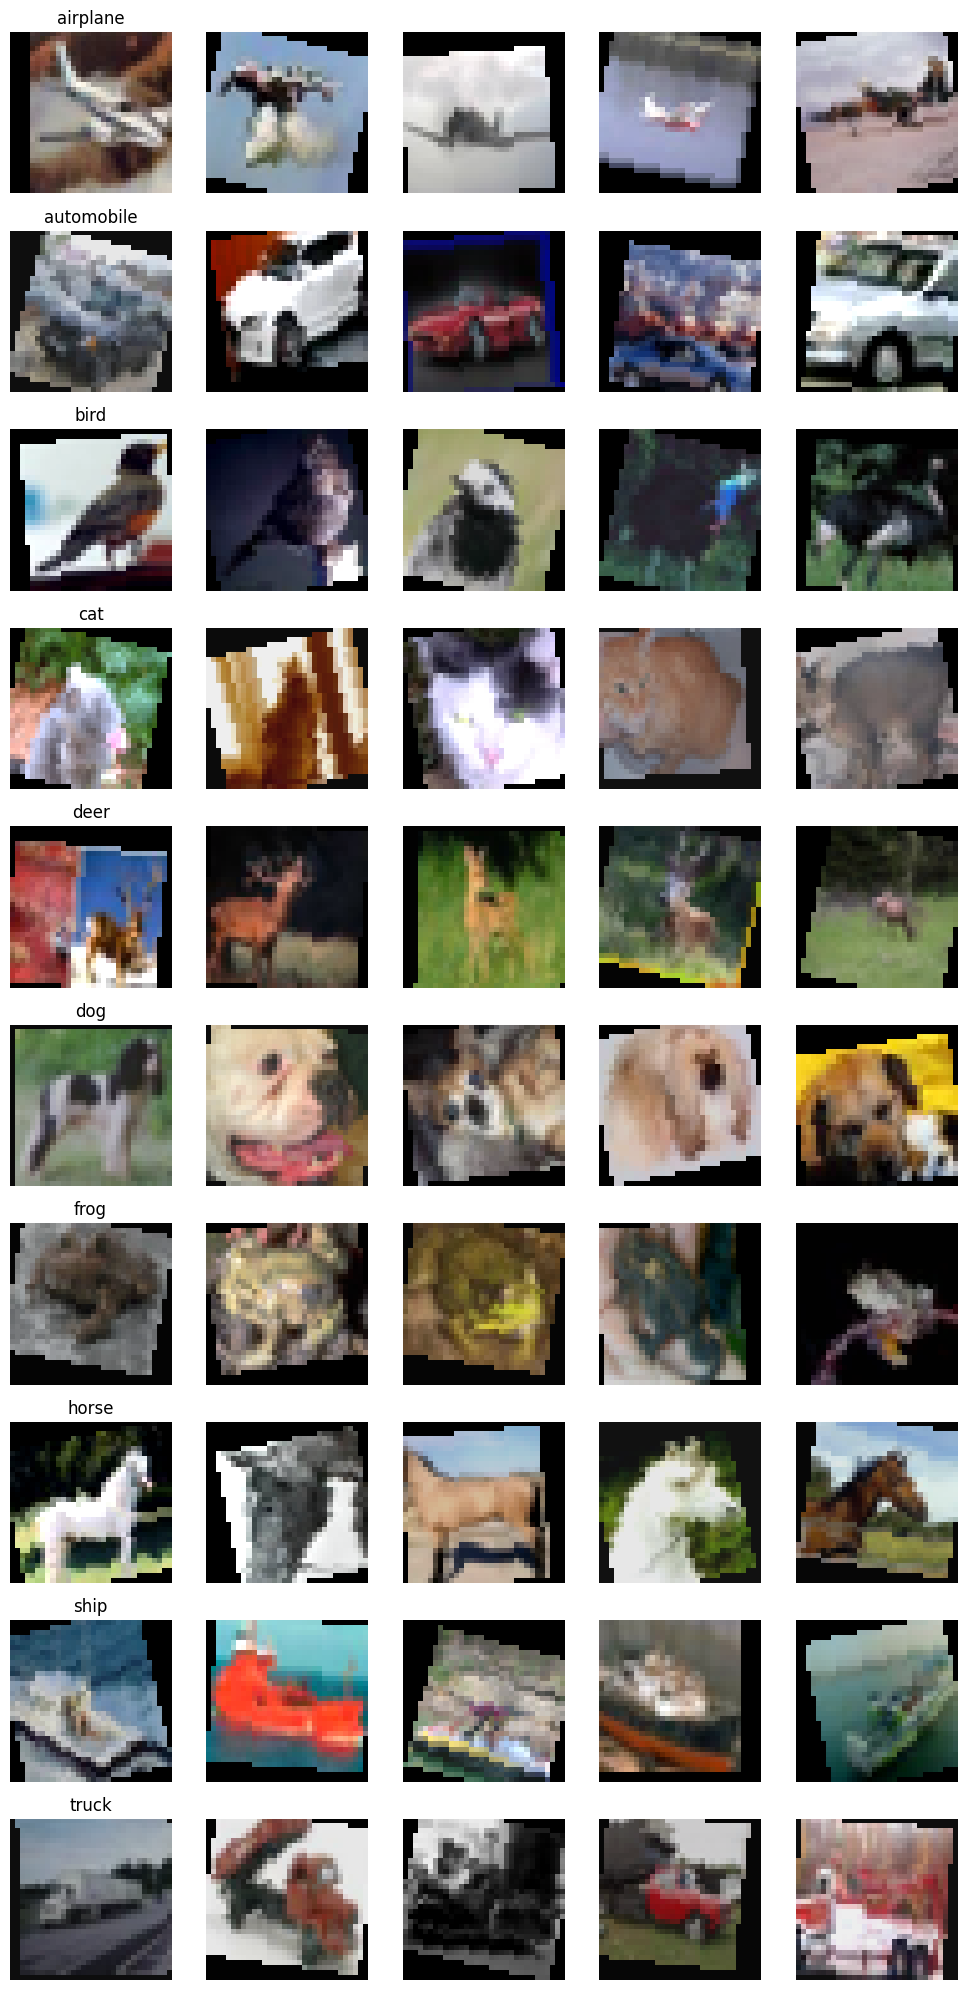

In [11]:
samples_per_class = 5
classes = cifar10_classes
class_images = {class_name: [] for class_name in classes}

for images, labels in train_loader:
    label = labels[0].item()
    class_name = classes[label]

    if len(class_images[class_name]) < samples_per_class:
        class_images[class_name].append(images[0])

    if all(len(images) == samples_per_class for images in class_images.values()):
        break

# Function to unnormalize and convert tensor to image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Plotting in grid
fig, axes = plt.subplots(nrows=len(classes), ncols=samples_per_class, figsize=(10, 20))

for i, class_name in enumerate(classes):
    for j in range(samples_per_class):
        ax = axes[i, j]
        ax.imshow(imshow(class_images[class_name][j]))
        ax.axis('off')
        if j == 0:
            ax.set_title(class_name)

plt.tight_layout()
plt.show()


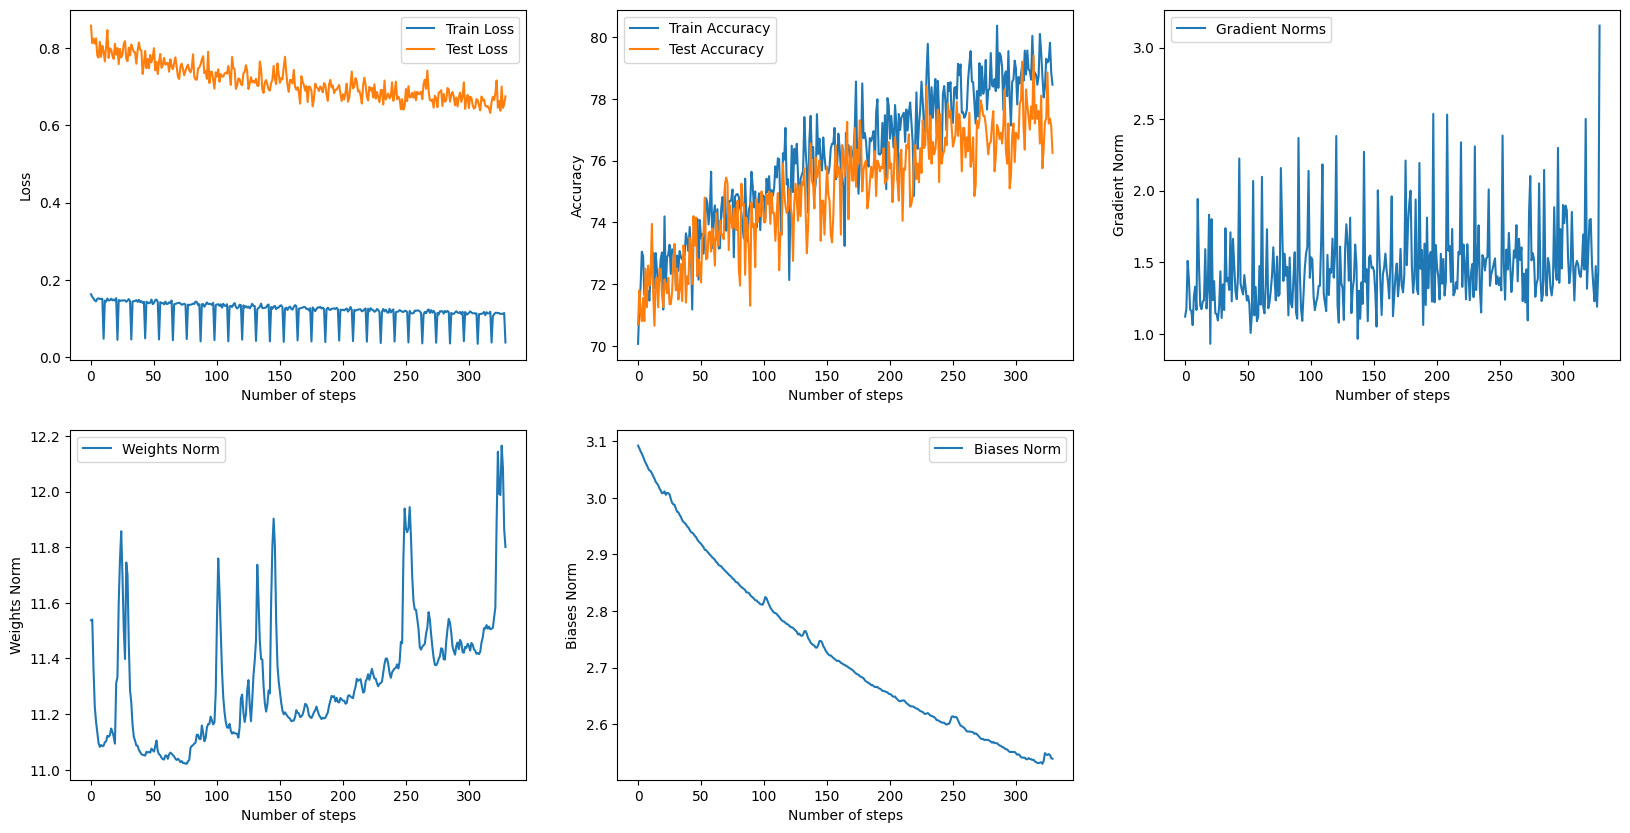

Epoch [30/30], Step [196/196], Loss: 0.7509
Training finished.


In [18]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
criterion= criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


# Initialize lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
gradient_norms = []
weights_norms = []
biases_norms = []

# Select a random subset for test evaluation to save computation
num_test_samples = 2000  # Adjust as needed
subset_indices = random.sample(range(len(test_dataset)), num_test_samples)
test_subset = Subset(test_dataset, subset_indices)
test_subset_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    total_steps = len(train_loader)
    plot_interval = total_steps // 10  # Calculate 10% of total steps


    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)


        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()

        # Log gradient norms
        total_norm = 0
        for p in model.parameters():
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5

        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Check if the current step is at the 10% interval
        if (i + 1) % plot_interval == 0 or i == total_steps - 1:
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            with torch.no_grad():
                for test_images, test_labels in test_subset_loader:
                    test_images, test_labels = test_images.to(device), test_labels.type(torch.LongTensor).to(device)
                    test_outputs = model(test_images)
                    test_loss += criterion(test_outputs, test_labels).item()
                    _, test_predicted = test_outputs.max(1)
                    test_total += test_labels.size(0)
                    test_correct += test_predicted.eq(test_labels).sum().item()

            # Log metrics
            train_losses.append(running_loss / 100)
            test_losses.append(test_loss / len(test_subset_loader))
            train_accuracies.append(100. * correct / total)
            test_accuracies.append(100. * test_correct / test_total)
            gradient_norms.append(total_norm)

            # Log weights and biases norms
            weights_norm = np.mean([p.data.norm().item() for p in model.parameters() if p.dim() > 1])
            biases_norm = np.mean([p.data.norm().item() for p in model.parameters() if p.dim() == 1])
            weights_norms.append(weights_norm)
            biases_norms.append(biases_norm)

            # Plot metrics
            display.clear_output(wait=True)
            plt.figure(figsize=(20, 10))
            plt.subplot(2, 3, 1)
            plt.plot(train_losses, label='Train Loss')
            plt.plot(test_losses, label='Test Loss')
            plt.xlabel('Number of steps')
            plt.ylabel('Loss')
            plt.legend()
            plt.subplot(2, 3, 2)
            plt.plot(train_accuracies, label='Train Accuracy')
            plt.plot(test_accuracies, label='Test Accuracy')
            plt.xlabel('Number of steps')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.subplot(2, 3, 3)
            plt.plot(gradient_norms, label='Gradient Norms')
            plt.xlabel('Number of steps')
            plt.ylabel('Gradient Norm')
            plt.legend()
            plt.subplot(2, 3, 4)
            plt.plot(weights_norms, label='Weights Norm')
            plt.xlabel('Number of steps')
            plt.ylabel('Weights Norm')
            plt.legend()
            plt.subplot(2, 3, 5)
            plt.plot(biases_norms, label='Biases Norm')
            plt.xlabel('Number of steps')
            plt.ylabel('Biases Norm')
            plt.legend()
            plt.show()
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

            # Reset running metrics for the next 100 steps
            running_loss = 0.0
            correct = 0
            total = 0
            model.train()




print("Training finished.")

In [19]:
def save_model(state, filename="cifar_vit.pth"):
    print("=> Saving model")
    torch.save(state, filename)

# Save the model checkpoint
save_model({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
})

=> Saving model


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Testing the model
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the 10000 test images: {100 * correct / total} %')


Accuracy of the model on the 10000 test images: 74.15 %


In [15]:
if 'model' not in locals():
    model = resnet18()
    checkpoint = torch.load('cifar_resnet.pth')
    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)


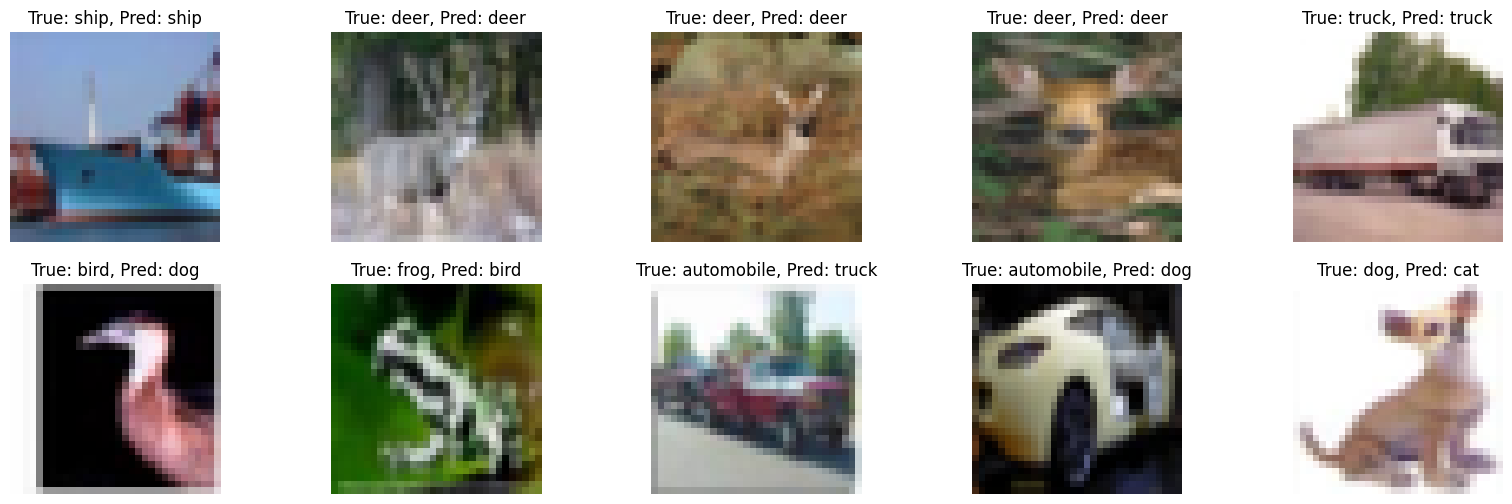

In [16]:
def denormalize_image(image):
    # Convert from [-1, 1] to [0, 1]
    image = image * 0.5 + 0.5
    return image

def visualize_predictions(dataset, model, device, num_images=10):
    model.eval()
    correct = 0
    incorrect = 0

    fig = plt.figure(figsize=(20, 6))

    with torch.no_grad():
        for images, labels in DataLoader(dataset, batch_size=1, shuffle=True):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            if (predicted == labels) and (correct < num_images // 2):
                correct += 1
                ax = fig.add_subplot(2, num_images // 2, correct)
                normalized_image = denormalize_image(images[0].cpu().numpy().transpose(1, 2, 0))
                ax.imshow(normalized_image)
                ax.set_title(f"True: {cifar10_classes[labels.item()]}, Pred: {cifar10_classes[predicted.item()]}")
                ax.axis('off')

            elif (predicted != labels) and (incorrect < num_images // 2):
                incorrect += 1
                ax = fig.add_subplot(2, num_images // 2, num_images // 2 + incorrect)
                # Normalize the image before displaying
                normalized_image = denormalize_image(images[0].cpu().numpy().transpose(1, 2, 0))
                ax.imshow(normalized_image)
                ax.set_title(f"True: {cifar10_classes[labels.item()]}, Pred: {cifar10_classes[predicted.item()]}")
                ax.axis('off')

            if correct >= num_images // 2 and incorrect >= num_images // 2:
                break

    plt.show()

# Visualize predictions
visualize_predictions(test_dataset, model, device)


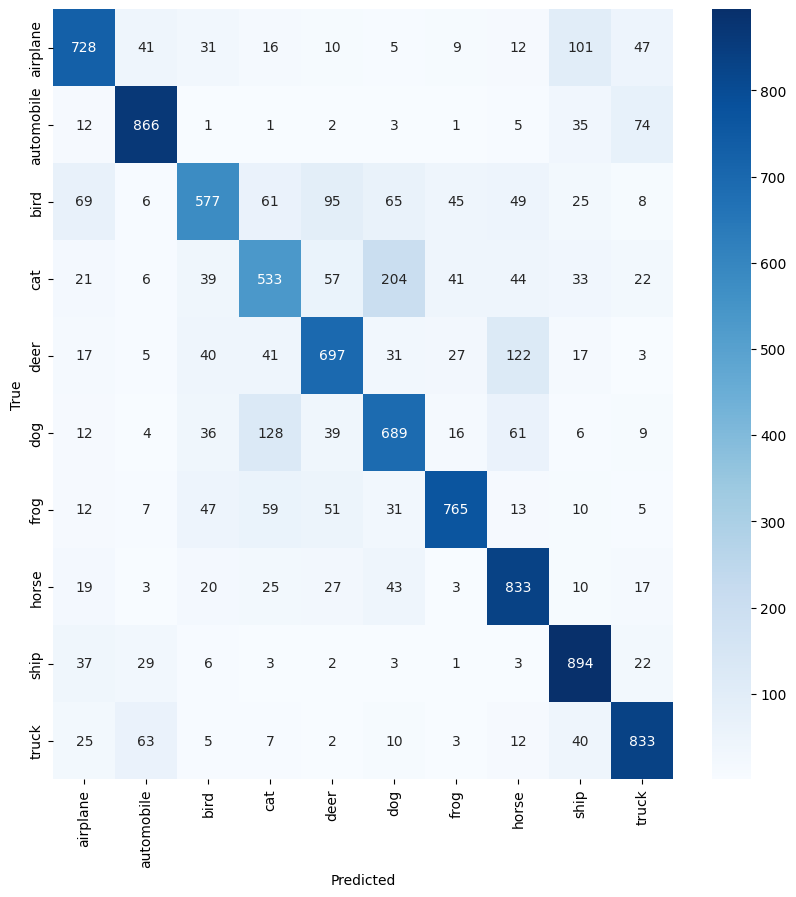

In [17]:
def plot_confusion_matrix(dataset, model, device, classes):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in DataLoader(dataset, batch_size=batch_size, shuffle=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_dataset, model, device, cifar10_classes)
